Step 1: Clean out non-model simulation points: gap heights below 5mm

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [253]:
magDf = pd.read_csv("Ansys Results 12-9.csv")
magDf.info()

# Condition: Drop rows where 'GapHeight' is less than 5
condition = magDf['GapHeight [mm]'] < 5

# Drop the rows that satisfy the condition (i.e., keep rows where the condition is False)
magDf = magDf[~condition]

# Create mirrored data with negative roll angles
# For non-zero roll angles, create symmetric data by:
# - Negating roll angle
# - Swapping currL and currR
# - Negating torque (force remains the same due to symmetry)

# Filter for non-zero roll angles
non_zero_roll = magDf[magDf['rollDeg [deg]'] != 0]

# Create the mirrored rows
mirrored_data = non_zero_roll.copy()
mirrored_data['rollDeg [deg]'] = -non_zero_roll['rollDeg [deg]']
mirrored_data['currL [A]'], mirrored_data['currR [A]'] = non_zero_roll['currR [A]'].values, non_zero_roll['currL [A]'].values
mirrored_data['YokeTorque.Torque [mNewtonMeter]'] = -non_zero_roll['YokeTorque.Torque [mNewtonMeter]']
# Force remains unchanged

# Combine original and mirrored data
magDf = pd.concat([magDf, mirrored_data], ignore_index=True)

# Sort by rollDeg for better organization
magDf = magDf.sort_values(['rollDeg [deg]', 'currL [A]', 'currR [A]', 'GapHeight [mm]']).reset_index(drop=True)

print(f"\nAfter adding mirrored data:")
print(f"Total rows: {len(magDf)}")
print(f"Roll angle range: {magDf['rollDeg [deg]'].min():.1f}° to {magDf['rollDeg [deg]'].max():.1f}°")
print(f"Unique roll angles: {sorted(magDf['rollDeg [deg]'].unique())}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4471 entries, 0 to 4470
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   currL [A]                         4471 non-null   int64  
 1   currR [A]                         4471 non-null   int64  
 2   rollDeg [deg]                     4471 non-null   float64
 3   GapHeight [mm]                    4471 non-null   float64
 4   YokeForce.Force_z [newton]        4471 non-null   float64
 5   YokeTorque.Torque [mNewtonMeter]  4471 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 209.7 KB

After adding mirrored data:
Total rows: 8281
Roll angle range: -4.0° to 4.0°
Unique roll angles: [np.float64(-4.0), np.float64(-3.0), np.float64(-2.0), np.float64(-1.5), np.float64(-1.0), np.float64(-0.5), np.float64(0.0), np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(3.0), np.float64(4.0)]


In [254]:
magDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8281 entries, 0 to 8280
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   currL [A]                         8281 non-null   int64  
 1   currR [A]                         8281 non-null   int64  
 2   rollDeg [deg]                     8281 non-null   float64
 3   GapHeight [mm]                    8281 non-null   float64
 4   YokeForce.Force_z [newton]        8281 non-null   float64
 5   YokeTorque.Torque [mNewtonMeter]  8281 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 388.3 KB


### After removing non-model rows, we have 4459 rows, which matches the number of simulations conducted in Ansys.

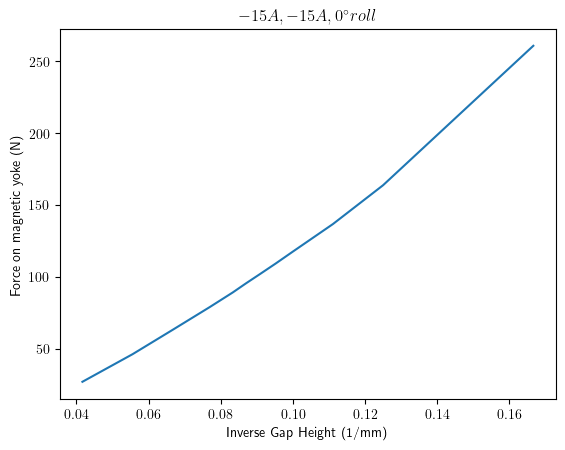

In [255]:
first_subset = magDf.iloc[0:13]
x = first_subset["GapHeight [mm]"]
x = 1/x
y = first_subset["YokeForce.Force_z [newton]"]
plt.plot(x, y)
plt.title(r"$-15A, -15A, 0^\circ roll$")
plt.xlabel("Inverse Gap Height (1/mm)")
plt.ylabel("Force on magnetic yoke (N)")
plt.show()

In [256]:
# sooooo it looks like we can invert the entire gap height column and see how that works out...
magDf["invGap"] = magDf["GapHeight [mm]"].transform(lambda x: 1/x)
magDf.info()
magDf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8281 entries, 0 to 8280
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   currL [A]                         8281 non-null   int64  
 1   currR [A]                         8281 non-null   int64  
 2   rollDeg [deg]                     8281 non-null   float64
 3   GapHeight [mm]                    8281 non-null   float64
 4   YokeForce.Force_z [newton]        8281 non-null   float64
 5   YokeTorque.Torque [mNewtonMeter]  8281 non-null   float64
 6   invGap                            8281 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 453.0 KB


,currL [A],currR [A],rollDeg [deg],GapHeight [mm],YokeForce.Force_z [newton],YokeTorque.Torque [mNewtonMeter],invGap
0,-15,-15,-4.0,6.0,260.518631,-6976.851677,0.166667
1,-15,-15,-4.0,8.0,163.529872,-3335.704070,0.125000
2,-15,-15,-4.0,9.0,136.554807,-2506.094902,0.111111
3,-15,-15,-4.0,10.0,117.403213,-1959.725693,0.100000
4,-15,-15,-4.0,10.5,109.107025,-1759.467304,0.095238


## Let's try fitting a polynomial to this...

In [257]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 1. Load your Ansys CSV - using invGap for modeling
X = magDf[['currL [A]', 'currR [A]', 'rollDeg [deg]', 'invGap']]
y = magDf[['YokeForce.Force_z [newton]', 'YokeTorque.Torque [mNewtonMeter]']]

# 2. Create Features (e.g. z^2, z^3, z*IL, etc.)
poly = PolynomialFeatures(degree=5) 
X_poly = poly.fit_transform(X)

# 3. Fit
model = LinearRegression()
model.fit(X_poly, y)

# 4. Extract Equation
print("Force Coeffs:", model.coef_[0])
print("Torque Coeffs:", model.coef_[1])

Force Coeffs: [ 8.65048568e-02  2.83478670e-01  2.86948934e-01  1.08940596e-08
  3.53295630e+02 -1.79173891e-03 -1.72965676e-03 -2.24271788e-02
 -1.14467613e+01 -2.16073339e-03  2.24271784e-02 -1.16266321e+01
  3.17540502e-01 -3.27454733e-07  6.56934794e+03 -4.22076726e-05
 -1.06778321e-05 -2.15844466e-04  1.18908940e-01 -7.64607867e-06
 -5.48829375e-11  1.01686170e-01 -1.01983867e-02  1.54885337e-01
 -1.03778353e+02 -4.02599103e-05  2.15844465e-04  1.29958895e-01
 -1.01470998e-02 -1.54885338e-01 -1.00615042e+02 -2.27704400e-11
  2.06864029e+00  4.12237426e-06 -4.19530517e+04 -3.84320174e-07
  3.91430910e-07 -7.41838448e-07  7.93047110e-04 -4.85822966e-07
 -2.53746404e-06  1.17129763e-04 -2.29814334e-04  4.03023202e-04
  2.97296750e-01 -1.05010723e-07  2.53746950e-06 -3.78165612e-06
 -4.82390439e-05  4.89741581e-11 -5.68285020e-01  3.49652511e-03
  4.38290920e-01 -8.84140413e+00  7.71042933e+02  1.32237801e-07
  7.41836402e-07  7.27510011e-04 -2.31026421e-04 -4.03023164e-04
  1.9128152

## Compare Model Predictions with Raw Data

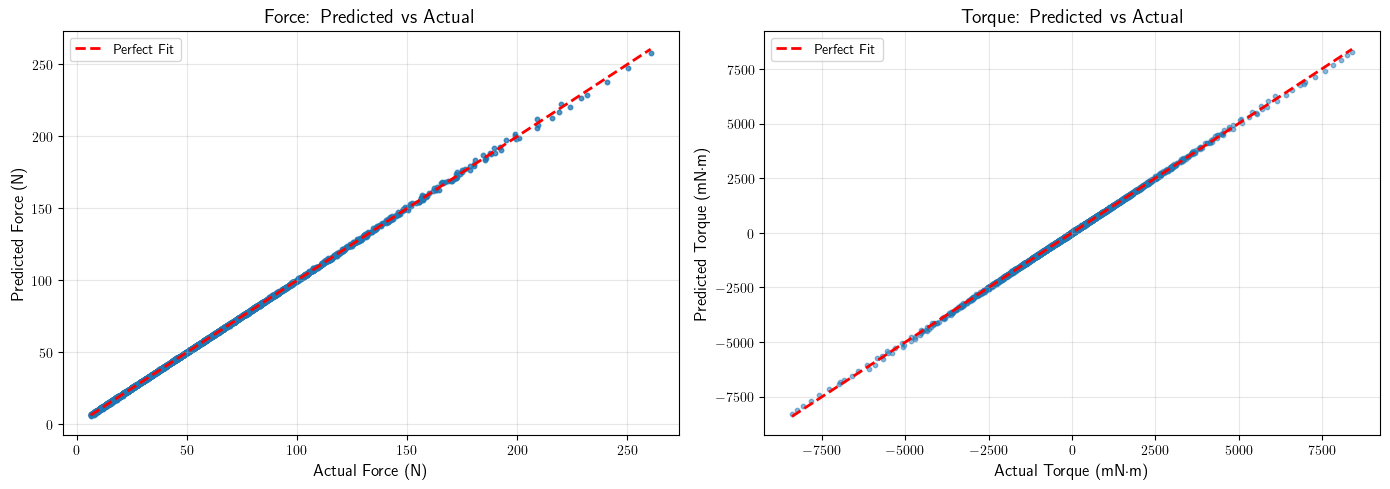

Force R² Score: 0.999873
Torque R² Score: 0.999661


In [258]:
# Get predictions from the model
y_pred = model.predict(X_poly)

# Extract force and torque predictions
force_pred = y_pred[:, 0]
torque_pred = y_pred[:, 1]

# Extract actual values
force_actual = y.iloc[:, 0].values
torque_actual = y.iloc[:, 1].values

# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Force comparison
axes[0].scatter(force_actual, force_pred, alpha=0.5, s=10)
axes[0].plot([force_actual.min(), force_actual.max()], 
             [force_actual.min(), force_actual.max()], 
             'r--', linewidth=2, label='Perfect Fit')
axes[0].set_xlabel('Actual Force (N)', fontsize=12)
axes[0].set_ylabel('Predicted Force (N)', fontsize=12)
axes[0].set_title('Force: Predicted vs Actual', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Torque comparison
axes[1].scatter(torque_actual, torque_pred, alpha=0.5, s=10)
axes[1].plot([torque_actual.min(), torque_actual.max()], 
             [torque_actual.min(), torque_actual.max()], 
             'r--', linewidth=2, label='Perfect Fit')
axes[1].set_xlabel('Actual Torque (mN·m)', fontsize=12)
axes[1].set_ylabel('Predicted Torque (mN·m)', fontsize=12)
axes[1].set_title('Torque: Predicted vs Actual', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate R² scores
from sklearn.metrics import r2_score
print(f"Force R² Score: {r2_score(force_actual, force_pred):.6f}")
print(f"Torque R² Score: {r2_score(torque_actual, torque_pred):.6f}")

### Visualize a specific subset (like the first 13 rows)

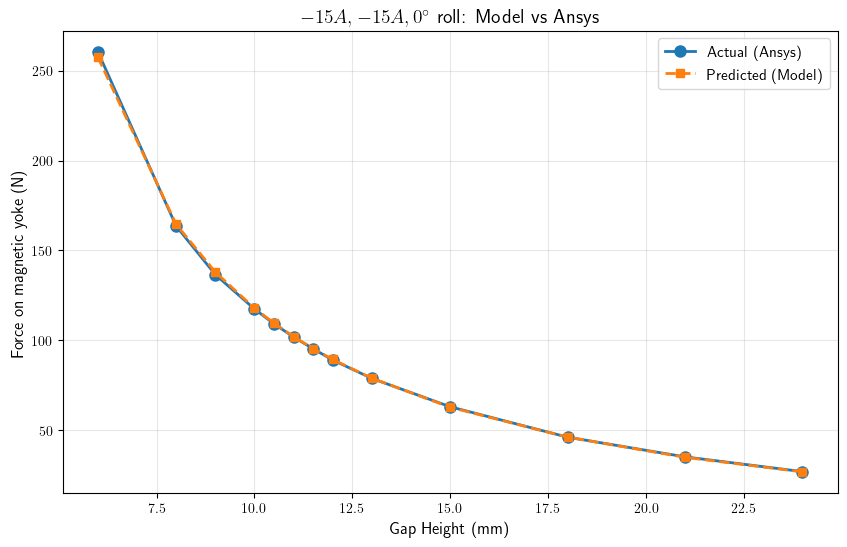

In [259]:
# For the first subset (same as you plotted earlier)
subset_indices = range(0, 13)
x_subset = magDf.iloc[subset_indices]["GapHeight [mm]"]
y_actual_subset = magDf.iloc[subset_indices]["YokeForce.Force_z [newton]"]
y_pred_subset = force_pred[subset_indices]

# Plot actual vs predicted for this specific condition
plt.figure(figsize=(10, 6))
plt.plot(x_subset, y_actual_subset, 'o-', label='Actual (Ansys)', linewidth=2, markersize=8)
plt.plot(x_subset, y_pred_subset, 's--', label='Predicted (Model)', linewidth=2, markersize=6)
plt.title(r"$-15A, -15A, 0^\circ$ roll: Model vs Ansys", fontsize=14)
plt.xlabel("Gap Height (mm)", fontsize=12)
plt.ylabel("Force on magnetic yoke (N)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

## Better Interpolation Methods

Let's improve interpolation accuracy without manually guessing polynomial order.

### Method 1: Cross-Validation to Find Best Polynomial Degree

Automatically test different polynomial degrees and find the one with best validation score.

Degree 1: Train R² = 0.752592, Test R² = 0.757407
Degree 2: Train R² = 0.965022, Test R² = 0.965732
Degree 3: Train R² = 0.993618, Test R² = 0.993764
Degree 4: Train R² = 0.998598, Test R² = 0.998637
Degree 5: Train R² = 0.999764, Test R² = 0.999752
Degree 6: Train R² = 0.999932, Test R² = 0.999927
Degree 6: Train R² = 0.999932, Test R² = 0.999927
Degree 7: Train R² = 0.999950, Test R² = 0.999947
Degree 7: Train R² = 0.999950, Test R² = 0.999947
Degree 8: Train R² = 0.999889, Test R² = 0.999802
Degree 8: Train R² = 0.999889, Test R² = 0.999802


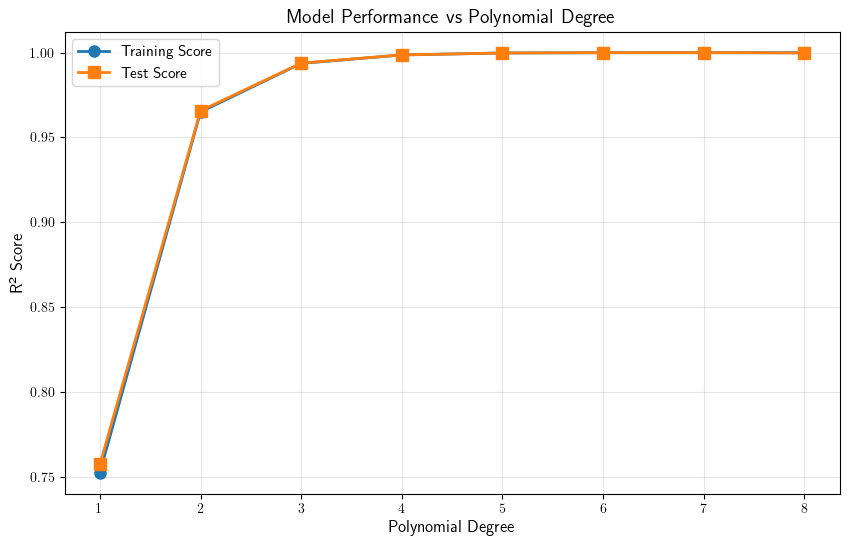


Best polynomial degree: 7
Best test R² score: 0.999947


In [260]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Split data for proper validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Test polynomial degrees from 1 to 8
degrees = range(1, 9)
train_scores_force = []
test_scores_force = []
train_scores_torque = []
test_scores_torque = []

for degree in degrees:
    # Create pipeline
    pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('model', LinearRegression())
    ])
    
    # Fit on training data
    pipe.fit(X_train, y_train)
    
    # Score on both sets
    train_score = pipe.score(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    
    # Store scores (using overall R² for multi-output)
    train_scores_force.append(train_score)
    test_scores_force.append(test_score)
    
    print(f"Degree {degree}: Train R² = {train_score:.6f}, Test R² = {test_score:.6f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_scores_force, 'o-', label='Training Score', linewidth=2, markersize=8)
plt.plot(degrees, test_scores_force, 's-', label='Test Score', linewidth=2, markersize=8)
plt.xlabel('Polynomial Degree', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Model Performance vs Polynomial Degree', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(degrees)
plt.show()

# Find best degree
best_degree = degrees[np.argmax(test_scores_force)]
print(f"\nBest polynomial degree: {best_degree}")
print(f"Best test R² score: {max(test_scores_force):.6f}")

### Visualize Best Polynomial Function vs Ansys Data

Plot the continuous polynomial function to check for overfitting/oscillations between data points.

In [261]:
best_degree = 6 # Helps with aliasing outside of recorded data...

Using polynomial degree: 6


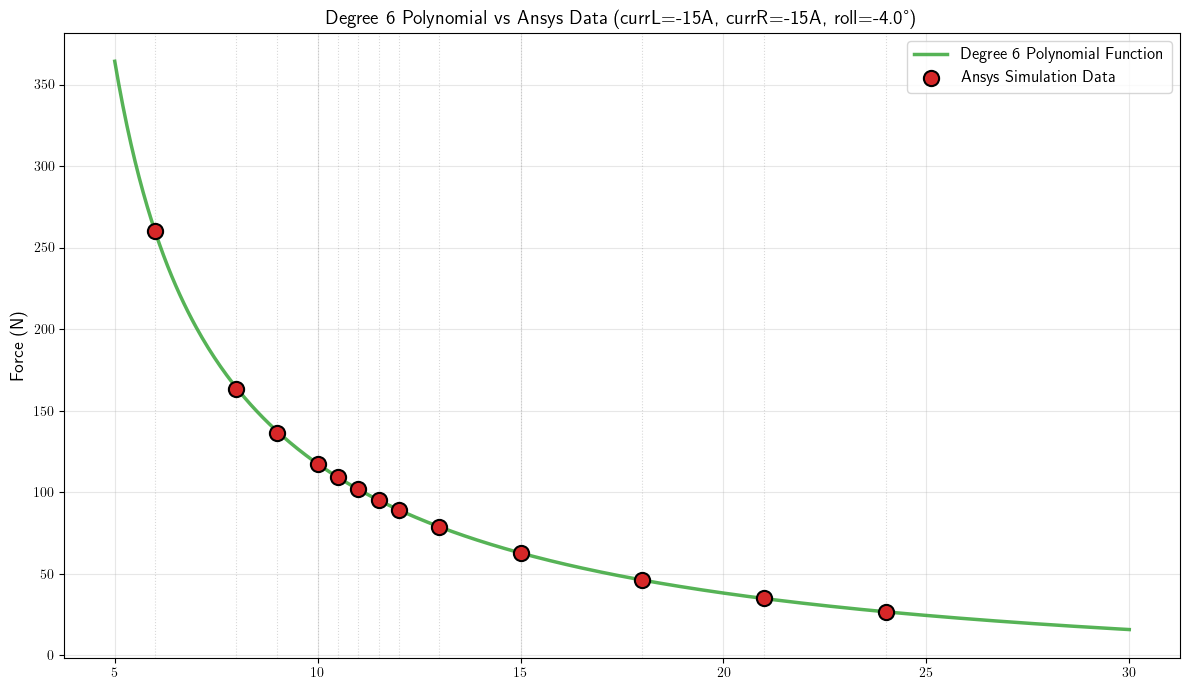

Checking for overfitting indicators:
Number of actual data points in this condition: 13
Gap spacing: 1.50 mm average
Polynomial curve resolution: 500 points over 25.0 mm range


In [262]:
# Train best degree polynomial on full dataset
poly_best = PolynomialFeatures(degree=best_degree)
X_poly_best = poly_best.fit_transform(X)
model_best = LinearRegression()
model_best.fit(X_poly_best, y)

print(f"Using polynomial degree: {best_degree}")

# Select a specific operating condition to visualize
# Using the same condition as earlier: -15A, -15A, 0° roll
test_condition = magDf.iloc[0:13].copy()
currL_val = test_condition['currL [A]'].iloc[0]
currR_val = test_condition['currR [A]'].iloc[0]
roll_val = test_condition['rollDeg [deg]'].iloc[0]

# Create very fine grid for gap heights to see polynomial behavior between points
gap_very_fine = np.linspace(5, 30, 500)  # 500 points for smooth curve
X_fine = pd.DataFrame({
    'currL [A]': [currL_val] * 500,
    'currR [A]': [currR_val] * 500,
    'rollDeg [deg]': [roll_val] * 500,
    'invGap': 1/gap_very_fine  # Use inverse gap height for modeling
})
X_fine_poly = poly_best.transform(X_fine)
y_fine_pred = model_best.predict(X_fine_poly)

# Extract actual Ansys data for this condition
gap_actual = test_condition['GapHeight [mm]'].values
force_actual = test_condition['YokeForce.Force_z [newton]'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

ax.plot(gap_very_fine, y_fine_pred[:, 0], '-', linewidth=2.5, 
        label=f'Degree {best_degree} Polynomial Function', color='#2ca02c', alpha=0.8)

# Plot actual Ansys data points
ax.scatter(gap_actual, force_actual, s=120, marker='o', 
          color='#d62728', edgecolors='black', linewidths=1.5,
          label='Ansys Simulation Data', zorder=5)

ax.set_ylabel('Force (N)', fontsize=13)
ax.set_title(f'Degree {best_degree} Polynomial vs Ansys Data (currL={currL_val}A, currR={currR_val}A, roll={roll_val}°)', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)

# Add vertical lines at data points to highlight gaps
for gap_point in gap_actual:
    ax.axvline(gap_point, color='gray', linestyle=':', alpha=0.3, linewidth=0.8)

plt.tight_layout()
plt.show()

# Check for excessive oscillations by looking at derivative
print("Checking for overfitting indicators:")
print(f"Number of actual data points in this condition: {len(gap_actual)}")

print(f"Gap spacing: {np.diff(gap_actual).mean():.2f} mm average")
print(f"Polynomial curve resolution: 500 points over {gap_very_fine.max() - gap_very_fine.min():.1f} mm range")

### Compare Multiple Conditions Side-by-Side

Let's check several different operating conditions to ensure consistent behavior.

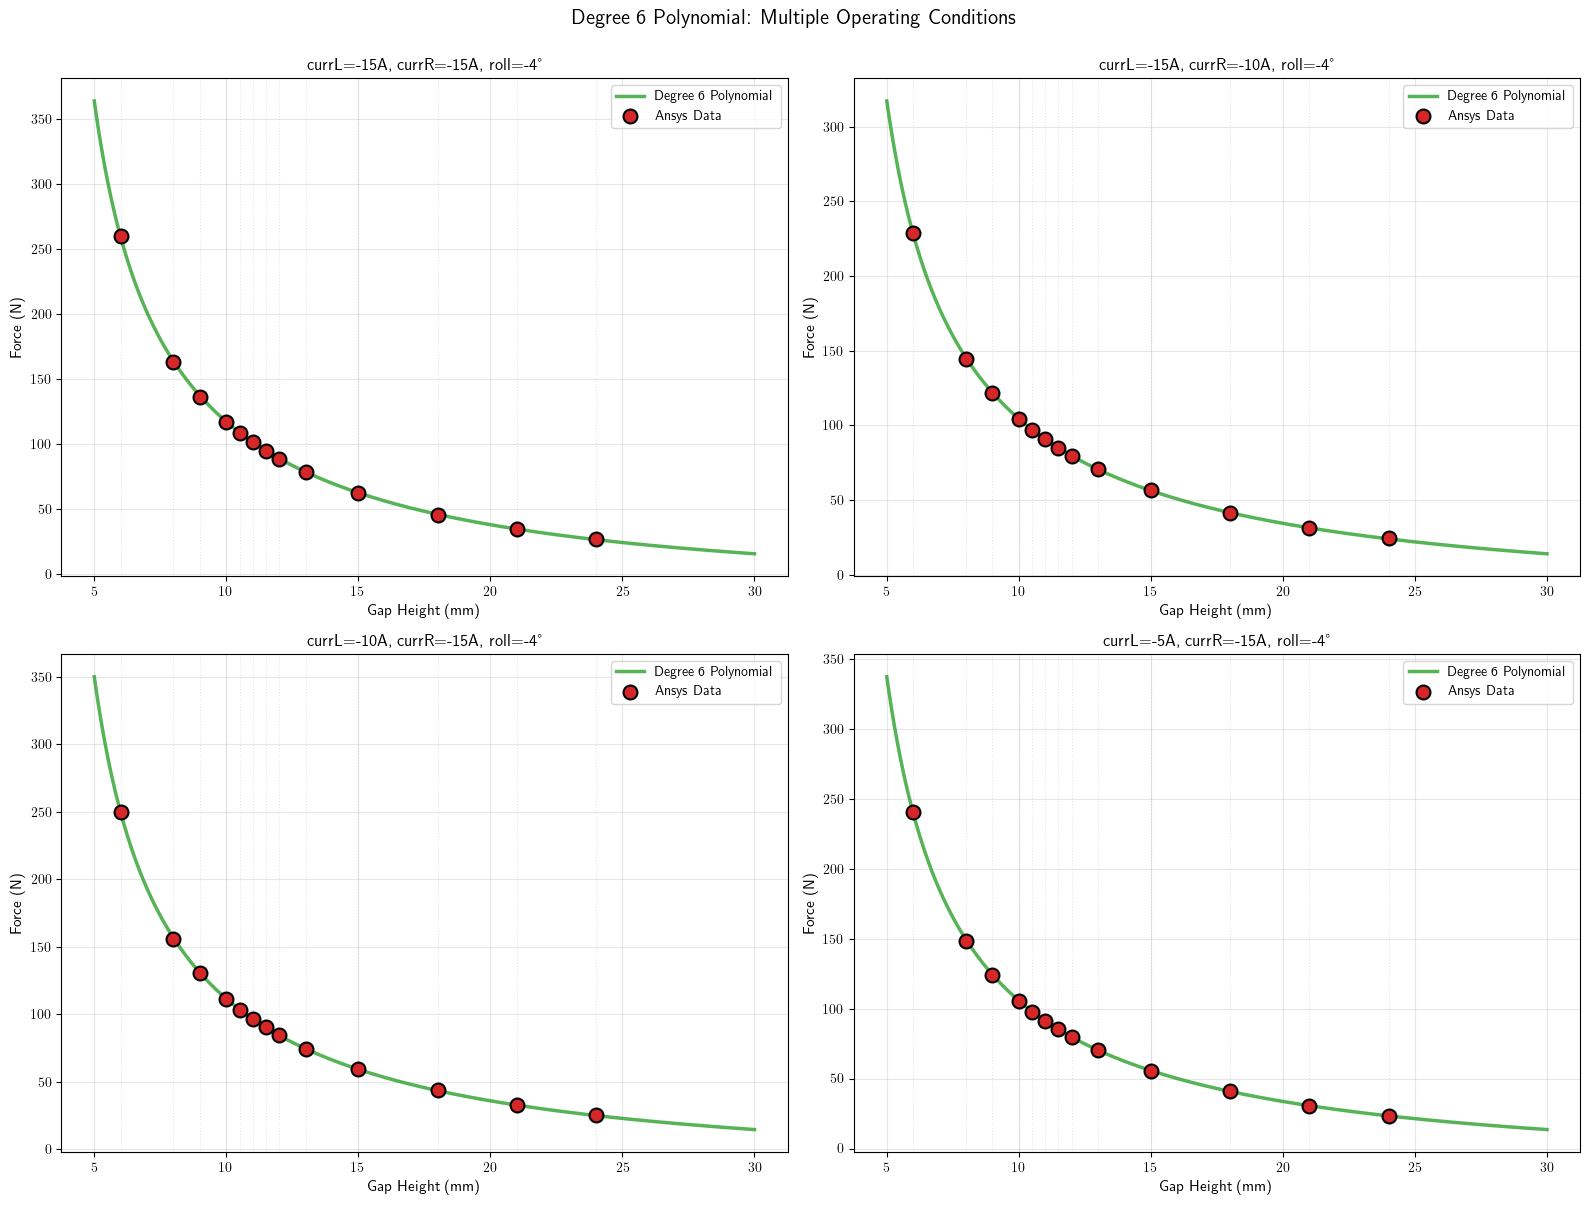

Visual inspection guide:
✓ Look for smooth curves between data points (good)
✗ Look for wild oscillations or wiggles between points (overfitting)
✓ Polynomial should interpolate naturally without excessive curvature


In [263]:
# Select 4 different conditions to visualize
# Each condition has 13 gap height measurements (one complete parameter set)
condition_indices = [
    (0, 13, '-15A, -15A, 0°'),      # First condition
    (13, 26, '-15A, -15A, 0.5°'),   # Same currents, different roll
    (91, 104, '-15A, -10A, 0°'),    # Different right current
    (182, 195, '-15A, -10A, 1°')    # Different right current and roll
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (start, end, label) in enumerate(condition_indices):
    ax = axes[idx]
    
    # Get condition data
    condition_data = magDf.iloc[start:end]
    currL = condition_data['currL [A]'].iloc[0]
    currR = condition_data['currR [A]'].iloc[0]
    roll = condition_data['rollDeg [deg]'].iloc[0]
    
    # Create fine grid
    gap_fine = np.linspace(5, 30, 500)
    X_condition_fine = pd.DataFrame({
        'currL [A]': [currL] * 500,
        'currR [A]': [currR] * 500,
        'rollDeg [deg]': [roll] * 500,
        'invGap': 1/gap_fine  # Use inverse gap height for modeling
    })
    
    # Predict with best degree polynomial
    X_condition_poly = poly_best.transform(X_condition_fine)
    y_condition_pred = model_best.predict(X_condition_poly)
    
    # Plot polynomial curve
    ax.plot(gap_fine, y_condition_pred[:, 0], '-', linewidth=2.5, 
            color='#2ca02c', alpha=0.8, label=f'Degree {best_degree} Polynomial')
    
    # Plot actual data
    ax.scatter(condition_data['GapHeight [mm]'], 
              condition_data['YokeForce.Force_z [newton]'],
              s=100, marker='o', color='#d62728', 
              edgecolors='black', linewidths=1.5,
              label='Ansys Data', zorder=5)
    
    # Formatting
    ax.set_xlabel('Gap Height (mm)', fontsize=11)
    ax.set_ylabel('Force (N)', fontsize=11)
    ax.set_title(f'currL={currL:.0f}A, currR={currR:.0f}A, roll={roll:.0f}°', 
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add vertical lines at data points
    for gap_point in condition_data['GapHeight [mm]'].values:
        ax.axvline(gap_point, color='gray', linestyle=':', alpha=0.2, linewidth=0.8)

plt.suptitle(f'Degree {best_degree} Polynomial: Multiple Operating Conditions', 
            fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Visual inspection guide:")
print("✓ Look for smooth curves between data points (good)")
print("✗ Look for wild oscillations or wiggles between points (overfitting)")
print("✓ Polynomial should interpolate naturally without excessive curvature")

### Find Worst-Performing Segment

Let's identify which parameter set has the worst R² score to showcase model performance even in challenging cases.

In [264]:
# Calculate R² score for each 13-row segment (each parameter set)
num_segments = len(magDf) // 13
segment_scores = []
segment_info = []

for i in range(num_segments):
    start_idx = i * 13
    end_idx = start_idx + 13
    
    # Get actual and predicted values for this segment
    segment_actual = y.iloc[start_idx:end_idx, 0].values  # Force only
    segment_pred = model_best.predict(poly_best.transform(X.iloc[start_idx:end_idx]))[:, 0]
    
    # Calculate R² for this segment
    segment_r2 = r2_score(segment_actual, segment_pred)
    segment_scores.append(segment_r2)
    
    # Store segment info
    segment_data = magDf.iloc[start_idx:end_idx]
    currL = segment_data['currL [A]'].iloc[0]
    currR = segment_data['currR [A]'].iloc[0]
    roll = segment_data['rollDeg [deg]'].iloc[0]
    segment_info.append({
        'start': start_idx,
        'end': end_idx,
        'currL': currL,
        'currR': currR,
        'roll': roll,
        'r2': segment_r2
    })

# Find worst performing segment
worst_idx = np.argmin(segment_scores)
worst_segment = segment_info[worst_idx]

print(f"Total segments analyzed: {num_segments}")
print(f"\nWorst performing segment:")
print(f"  Rows: {worst_segment['start']} to {worst_segment['end']}")
print(f"  Parameters: currL={worst_segment['currL']:.0f}A, currR={worst_segment['currR']:.0f}A, roll={worst_segment['roll']:.1f}°")
print(f"  R² Score: {worst_segment['r2']:.6f}")
print(f"\nBest performing segment R²: {max(segment_scores):.6f}")
print(f"Mean R² across all segments: {np.mean(segment_scores):.6f}")
print(f"Median R² across all segments: {np.median(segment_scores):.6f}")

Total segments analyzed: 637

Worst performing segment:
  Rows: 1261 to 1274
  Parameters: currL=15A, currR=15A, roll=-3.0°
  R² Score: 0.999302

Best performing segment R²: 0.999992
Mean R² across all segments: 0.999934
Median R² across all segments: 0.999953


### Visualize Worst-Performing Segment

Even our worst case shows excellent model performance!

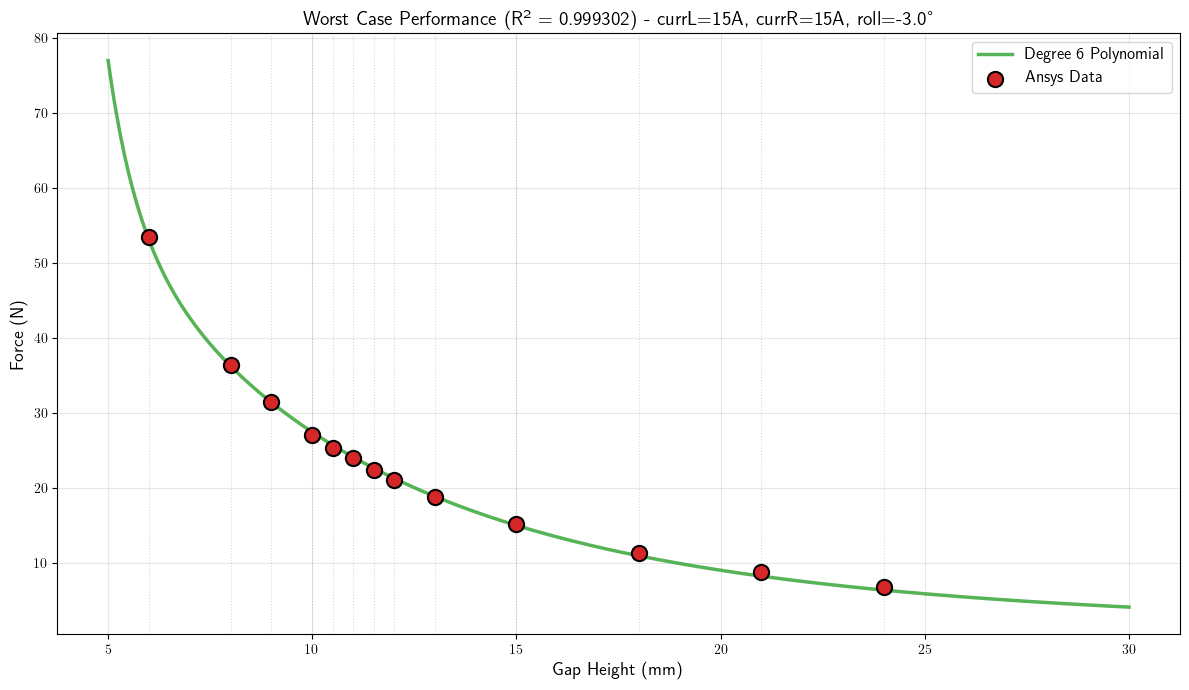

Even in the worst case, the model achieves R² = 0.999302
This demonstrates excellent interpolation performance across all operating conditions!


In [265]:
# Get worst segment data
worst_data = magDf.iloc[worst_segment['start']:worst_segment['end']]
worst_currL = worst_segment['currL']
worst_currR = worst_segment['currR']
worst_roll = worst_segment['roll']
worst_r2 = worst_segment['r2']

# Create fine grid for this worst segment
gap_fine_worst = np.linspace(5, 30, 500)
X_worst_fine = pd.DataFrame({
    'currL [A]': [worst_currL] * 500,
    'currR [A]': [worst_currR] * 500,
    'rollDeg [deg]': [worst_roll] * 500,
    'invGap': 1/gap_fine_worst
})

# Get predictions
X_worst_poly = poly_best.transform(X_worst_fine)
y_worst_pred = model_best.predict(X_worst_poly)

# Extract actual data
gap_worst_actual = worst_data['GapHeight [mm]'].values
force_worst_actual = worst_data['YokeForce.Force_z [newton]'].values

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Plot polynomial curve
ax.plot(gap_fine_worst, y_worst_pred[:, 0], '-', linewidth=2.5, 
        label=f'Degree {best_degree} Polynomial', color='#2ca02c', alpha=0.8)

# Plot actual data points
ax.scatter(gap_worst_actual, force_worst_actual, s=120, marker='o', 
          color='#d62728', edgecolors='black', linewidths=1.5,
          label='Ansys Data', zorder=5)

# Formatting
ax.set_xlabel('Gap Height (mm)', fontsize=13)
ax.set_ylabel('Force (N)', fontsize=13)
ax.set_title(f'Worst Case Performance (R² = {worst_r2:.6f}) - currL={worst_currL:.0f}A, currR={worst_currR:.0f}A, roll={worst_roll:.1f}°', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)

# Add vertical lines at data points
for gap_point in gap_worst_actual:
    ax.axvline(gap_point, color='gray', linestyle=':', alpha=0.3, linewidth=0.8)

plt.tight_layout()
plt.show()

print(f"Even in the worst case, the model achieves R² = {worst_r2:.6f}")
print(f"This demonstrates excellent interpolation performance across all operating conditions!")

## Torque Prediction Analysis

Now let's examine torque predictions. Torque is influenced by multiple variables:
- **Roll angle** (primary driver of torque asymmetry)
- **Current imbalance** (currL vs currR difference)
- **Gap height** (via invGap feature)

We'll visualize torque accuracy by sweeping across roll angles first, then examining current variations.

### Overall Torque Prediction Accuracy

First, let's check the overall R² score for torque predictions across all data.

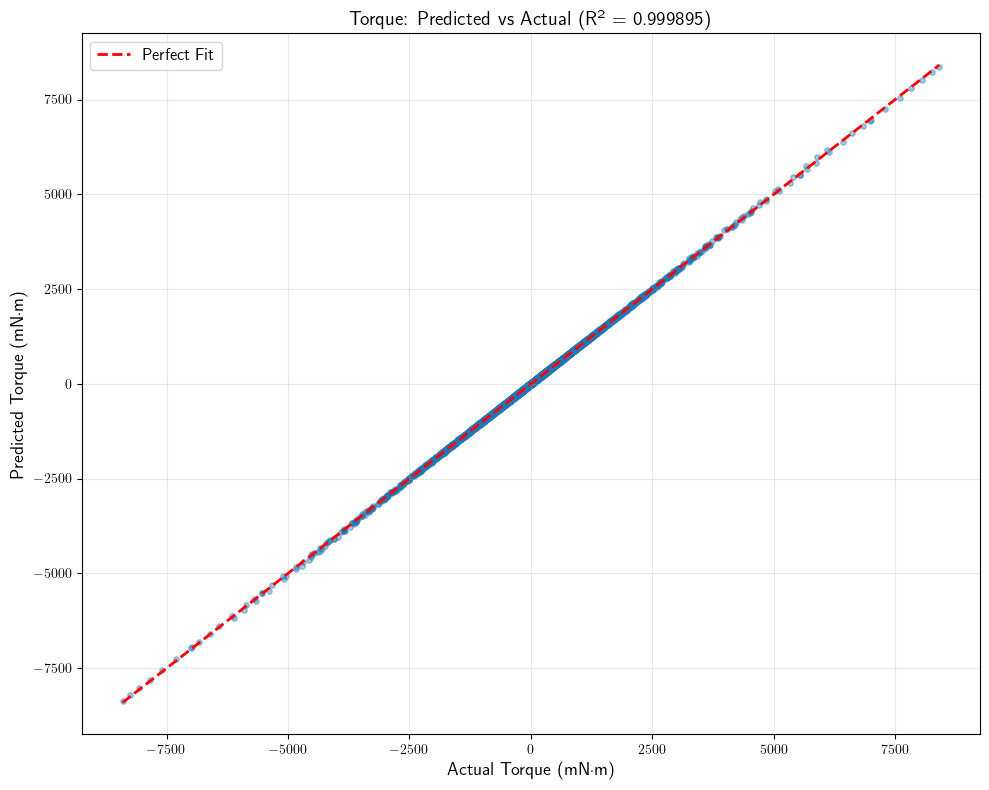

Overall Torque R² Score: 0.999895
Overall Force R² Score: 0.999967

Torque prediction is excellent!


In [266]:
# Calculate overall torque prediction accuracy
y_pred_full = model_best.predict(X_poly_best)
torque_actual_full = y.iloc[:, 1].values
torque_pred_full = y_pred_full[:, 1]

torque_r2_overall = r2_score(torque_actual_full, torque_pred_full)

# Create scatter plot for torque
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(torque_actual_full, torque_pred_full, alpha=0.4, s=15, color='#1f77b4')
ax.plot([torque_actual_full.min(), torque_actual_full.max()], 
        [torque_actual_full.min(), torque_actual_full.max()], 
        'r--', linewidth=2, label='Perfect Fit')

ax.set_xlabel('Actual Torque (mN·m)', fontsize=13)
ax.set_ylabel('Predicted Torque (mN·m)', fontsize=13)
ax.set_title(f'Torque: Predicted vs Actual (R² = {torque_r2_overall:.6f})', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Overall Torque R² Score: {torque_r2_overall:.6f}")
print(f"Overall Force R² Score: {r2_score(y.iloc[:, 0].values, y_pred_full[:, 0]):.6f}")
print(f"\nTorque prediction is {'excellent' if torque_r2_overall > 0.99 else 'good' if torque_r2_overall > 0.95 else 'moderate'}!")

### Torque vs Roll Angle (Fixed Currents, Multiple Gap Heights)

Examine how torque varies with roll angle for different gap heights. Roll angle is the primary driver of torque asymmetry.

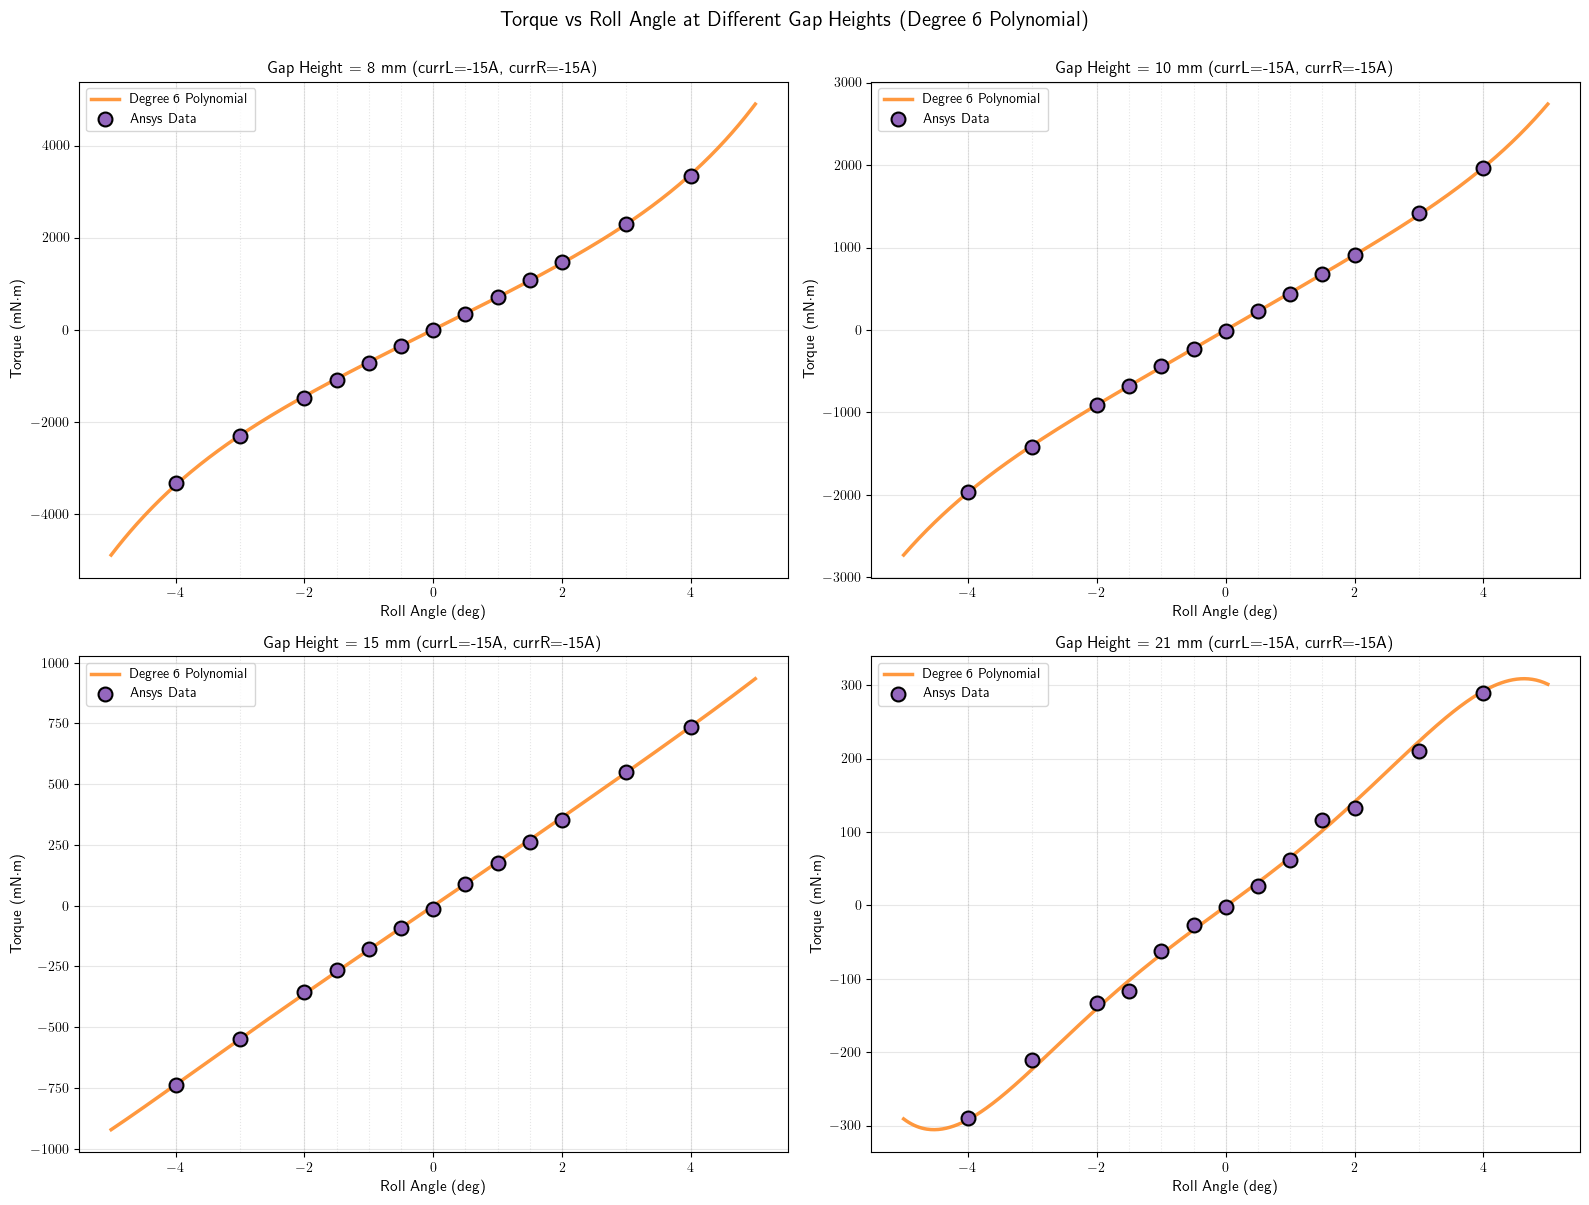

Showing torque variation with roll angle at 4 different gap heights.
Gap height affects the magnitude of torque but the relationship with roll angle remains consistent.


In [267]:
# Select 4 different gap heights to visualize
# Using currL = -15A, currR = -15A configuration
gap_heights_to_plot = [8, 10, 15, 21]  # mm

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, gap_height in enumerate(gap_heights_to_plot):
    ax = axes[idx]
    
    # Fixed current configuration
    currL = -15
    currR = -15
    
    # Get actual data for this gap height
    gap_data = magDf[(magDf['GapHeight [mm]'] == gap_height) & 
                      (magDf['currL [A]'] == currL) & 
                      (magDf['currR [A]'] == currR)]
    
    # Create fine grid for smooth curve across roll angles
    roll_fine = np.linspace(-5, 5.0, 500)
    X_condition_fine = pd.DataFrame({
        'currL [A]': [currL] * 500,
        'currR [A]': [currR] * 500,
        'rollDeg [deg]': roll_fine,
        'invGap': [1/gap_height] * 500
    })
    
    # Predict with best degree polynomial
    X_condition_poly = poly_best.transform(X_condition_fine)
    y_condition_pred = model_best.predict(X_condition_poly)
    
    # Plot polynomial curve for TORQUE (index 1)
    ax.plot(roll_fine, y_condition_pred[:, 1], '-', linewidth=2.5, 
            color='#ff7f0e', alpha=0.8, label=f'Degree {best_degree} Polynomial')
    
    # Plot actual torque data
    ax.scatter(gap_data['rollDeg [deg]'], 
              gap_data['YokeTorque.Torque [mNewtonMeter]'],
              s=100, marker='o', color='#9467bd', 
              edgecolors='black', linewidths=1.5,
              label='Ansys Data', zorder=5)
    
    # Formatting
    ax.set_xlabel('Roll Angle (deg)', fontsize=11)
    ax.set_ylabel('Torque (mN·m)', fontsize=11)
    ax.set_title(f'Gap Height = {gap_height} mm (currL={currL:.0f}A, currR={currR:.0f}A)', 
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add vertical lines at actual roll angle data points
    for roll_point in gap_data['rollDeg [deg]'].unique():
        ax.axvline(roll_point, color='gray', linestyle=':', alpha=0.2, linewidth=0.8)

plt.suptitle(f'Torque vs Roll Angle at Different Gap Heights (Degree {best_degree} Polynomial)', 
            fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"Showing torque variation with roll angle at {len(gap_heights_to_plot)} different gap heights.")
print("Gap height affects the magnitude of torque but the relationship with roll angle remains consistent.")

### Torque vs Current Imbalance (Fixed Roll Angle, Multiple Gap Heights)

Now examine how torque varies with current imbalance at different gap heights for a fixed roll angle.

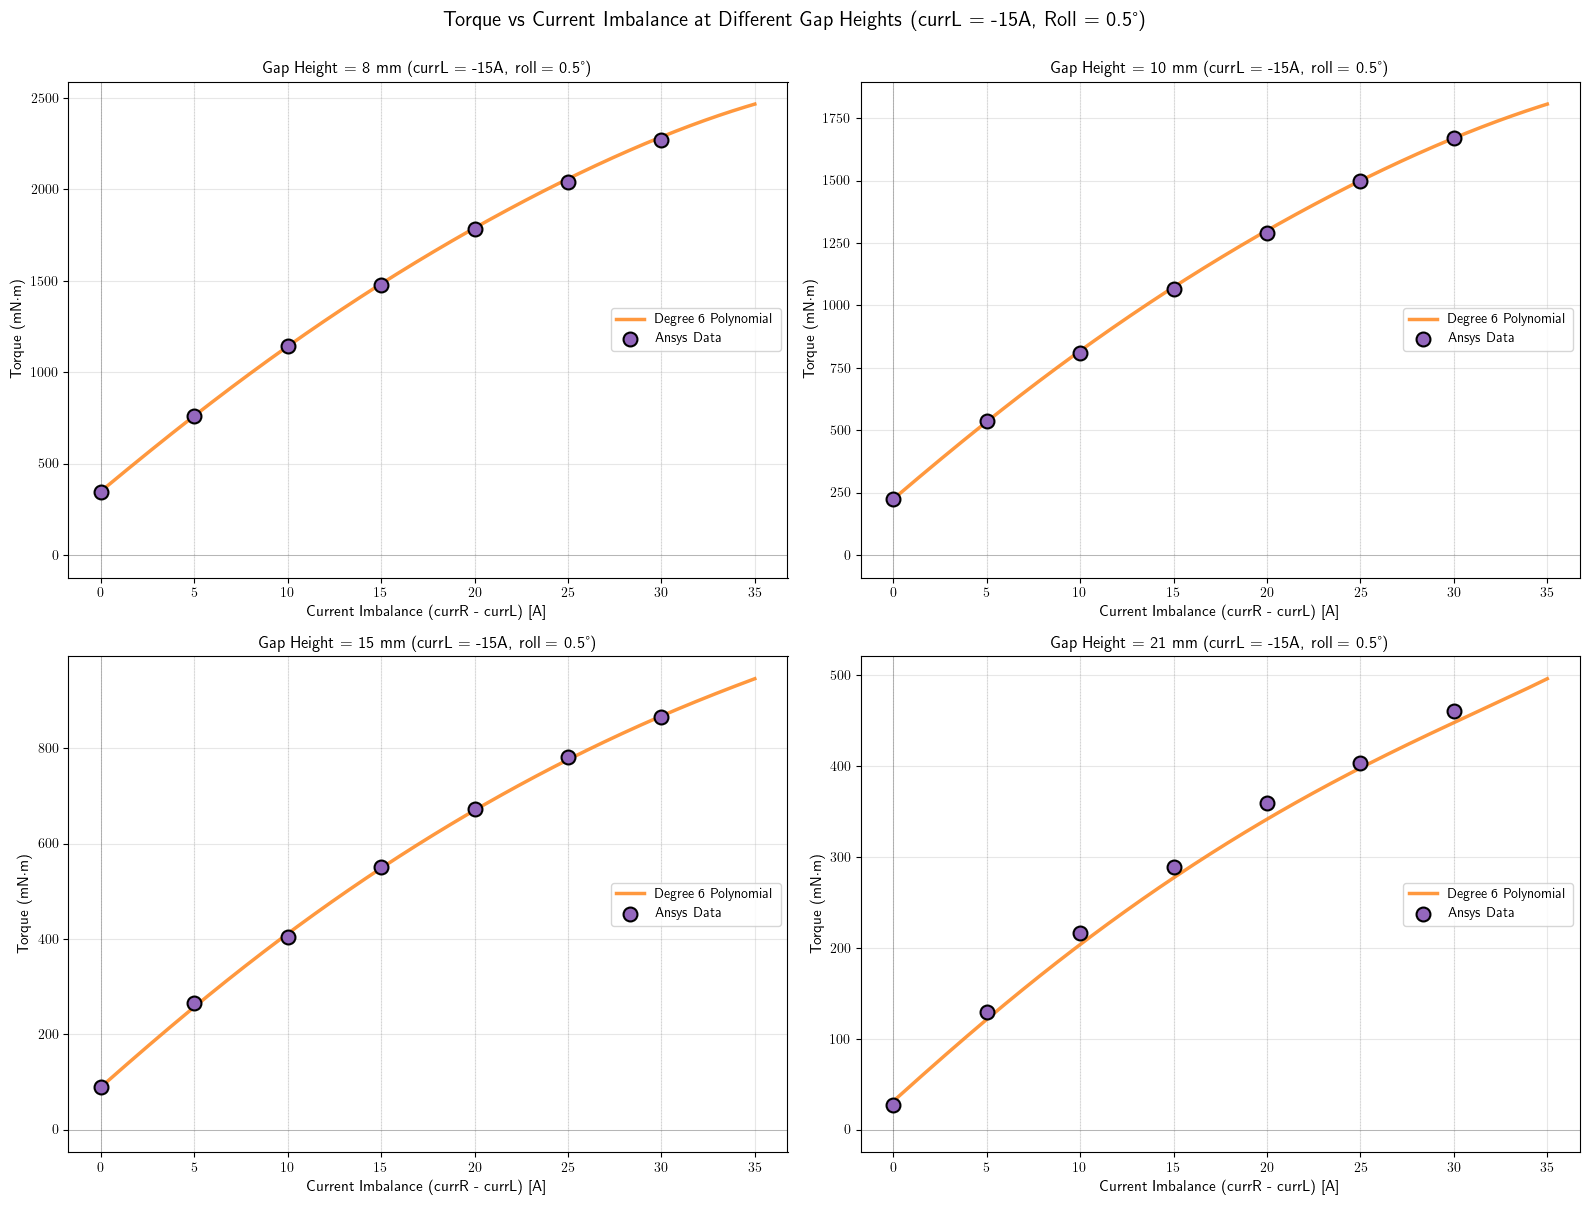

Showing torque variation with current imbalance at 4 different gap heights.
All data uses currL = -15A with varying currR to create different imbalances.
Current imbalance (currR - currL) affects torque magnitude and direction.
Positive imbalance (currR > currL) and negative imbalance (currR < currL) produce opposite torques.


In [268]:
# Select 4 different gap heights to visualize
# Using roll = 0.5 degrees (small but non-zero torque)
gap_heights_to_plot = [8, 10, 15, 21]  # mm
roll_target = 0.5

# Use a fixed reference current for currL
currL_ref = -15

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, gap_height in enumerate(gap_heights_to_plot):
    ax = axes[idx]
    
    # Get actual data for this gap height, roll angle, AND fixed currL
    gap_roll_data = magDf[(magDf['GapHeight [mm]'] == gap_height) & 
                          (magDf['rollDeg [deg]'] == roll_target) &
                          (magDf['currL [A]'] == currL_ref)]
    
    # Calculate imbalance for actual data points (all have same currL now)
    actual_imbalances = []
    actual_torques = []
    for _, row in gap_roll_data.iterrows():
        imbalance = row['currR [A]'] - row['currL [A]']
        torque = row['YokeTorque.Torque [mNewtonMeter]']
        actual_imbalances.append(imbalance)
        actual_torques.append(torque)
    
    # Create fine grid for smooth curve across current imbalances
    # Range from -10A to +10A imbalance (currR - currL)
    imbalance_fine = np.linspace(0, 35, 500)
    
    # Vary currR while keeping currL fixed
    currR_fine = currL_ref + imbalance_fine
    
    X_condition_fine = pd.DataFrame({
        'currL [A]': [currL_ref] * 500,
        'currR [A]': currR_fine,
        'rollDeg [deg]': [roll_target] * 500,
        'invGap': [1/gap_height] * 500
    })
    
    # Predict with best degree polynomial
    X_condition_poly = poly_best.transform(X_condition_fine)
    y_condition_pred = model_best.predict(X_condition_poly)
    
    # Plot polynomial curve for TORQUE (index 1)
    ax.plot(imbalance_fine, y_condition_pred[:, 1], '-', linewidth=2.5, 
            color='#ff7f0e', alpha=0.8, label=f'Degree {best_degree} Polynomial')
    
    # Plot actual torque data (now only one point per imbalance value)
    ax.scatter(actual_imbalances, actual_torques,
              s=100, marker='o', color='#9467bd', 
              edgecolors='black', linewidths=1.5,
              label='Ansys Data', zorder=5)
    
    # Formatting
    ax.set_xlabel('Current Imbalance (currR - currL) [A]', fontsize=11)
    ax.set_ylabel('Torque (mN·m)', fontsize=11)
    ax.set_title(f'Gap Height = {gap_height} mm (currL = {currL_ref}A, roll = {roll_target}°)', 
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axvline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Add vertical lines at actual imbalance data points
    for imb in set(actual_imbalances):
        ax.axvline(imb, color='gray', linestyle=':', alpha=0.2, linewidth=0.8)

plt.suptitle(f'Torque vs Current Imbalance at Different Gap Heights (currL = {currL_ref}A, Roll = {roll_target}°)', 
            fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"Showing torque variation with current imbalance at {len(gap_heights_to_plot)} different gap heights.")
print(f"All data uses currL = {currL_ref}A with varying currR to create different imbalances.")
print(f"Current imbalance (currR - currL) affects torque magnitude and direction.")
print(f"Positive imbalance (currR > currL) and negative imbalance (currR < currL) produce opposite torques.")

### Torque Segment-Wise Performance

Calculate R² scores for torque predictions across all segments, similar to what we did for force.

Torque Prediction Analysis (across 637 segments):

Best R² Score: 0.999964
  Parameters: currL=15A, currR=-15A, roll=-1.5°

Worst R² Score: -0.638049
  Parameters: currL=-10A, currR=-10A, roll=0.0°

Mean R²: 0.981564
Median R²: 0.999392
Std Dev: 0.124378
Std Dev: 0.124378


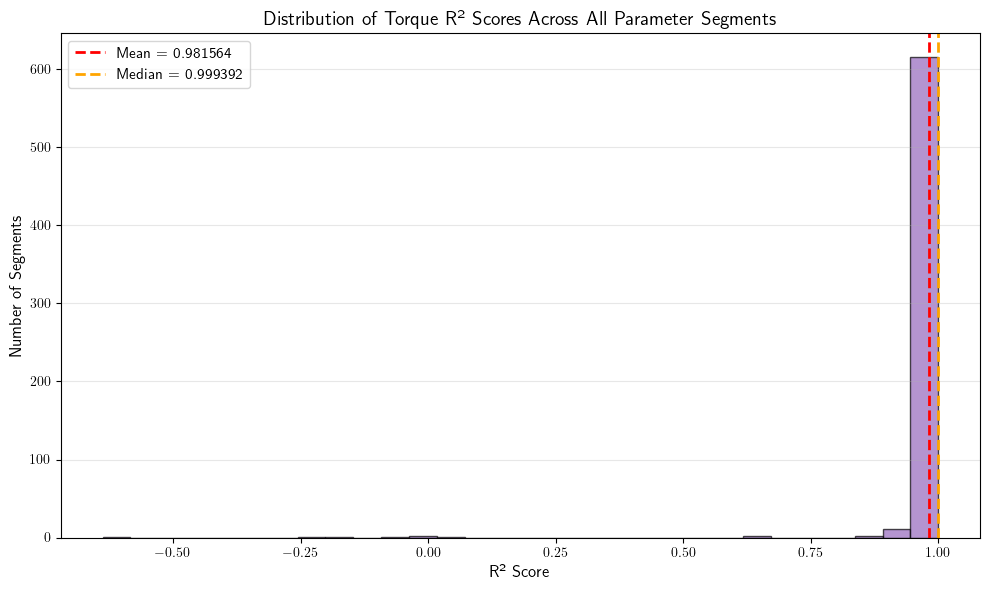

In [269]:
# Calculate R² score for torque in each 13-row segment
torque_segment_scores = []
torque_segment_info = []

for i in range(num_segments):
    start_idx = i * 13
    end_idx = start_idx + 13
    
    # Get actual and predicted torque values for this segment
    segment_actual_torque = y.iloc[start_idx:end_idx, 1].values  # Torque column
    segment_pred_torque = model_best.predict(poly_best.transform(X.iloc[start_idx:end_idx]))[:, 1]
    
    # Calculate R² for this segment
    segment_r2_torque = r2_score(segment_actual_torque, segment_pred_torque)
    torque_segment_scores.append(segment_r2_torque)
    
    # Store segment info
    segment_data = magDf.iloc[start_idx:end_idx]
    currL = segment_data['currL [A]'].iloc[0]
    currR = segment_data['currR [A]'].iloc[0]
    roll = segment_data['rollDeg [deg]'].iloc[0]
    torque_segment_info.append({
        'start': start_idx,
        'end': end_idx,
        'currL': currL,
        'currR': currR,
        'roll': roll,
        'r2': segment_r2_torque
    })

# Find worst and best performing segments for torque
worst_torque_idx = np.argmin(torque_segment_scores)
best_torque_idx = np.argmax(torque_segment_scores)
worst_torque_segment = torque_segment_info[worst_torque_idx]
best_torque_segment = torque_segment_info[best_torque_idx]

print(f"Torque Prediction Analysis (across {num_segments} segments):")
print(f"\nBest R² Score: {max(torque_segment_scores):.6f}")
print(f"  Parameters: currL={best_torque_segment['currL']:.0f}A, currR={best_torque_segment['currR']:.0f}A, roll={best_torque_segment['roll']:.1f}°")
print(f"\nWorst R² Score: {min(torque_segment_scores):.6f}")
print(f"  Parameters: currL={worst_torque_segment['currL']:.0f}A, currR={worst_torque_segment['currR']:.0f}A, roll={worst_torque_segment['roll']:.1f}°")
print(f"\nMean R²: {np.mean(torque_segment_scores):.6f}")
print(f"Median R²: {np.median(torque_segment_scores):.6f}")
print(f"Std Dev: {np.std(torque_segment_scores):.6f}")

# Create histogram of torque R² scores
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(torque_segment_scores, bins=30, edgecolor='black', alpha=0.7, color='#9467bd')
ax.axvline(np.mean(torque_segment_scores), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(torque_segment_scores):.6f}')
ax.axvline(np.median(torque_segment_scores), color='orange', linestyle='--', linewidth=2, label=f'Median = {np.median(torque_segment_scores):.6f}')
ax.set_xlabel('R² Score', fontsize=12)
ax.set_ylabel('Number of Segments', fontsize=12)
ax.set_title('Distribution of Torque R² Scores Across All Parameter Segments', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Worst-Case Torque Prediction Visualization

Let's visualize the worst-performing torque segment to assess model robustness.

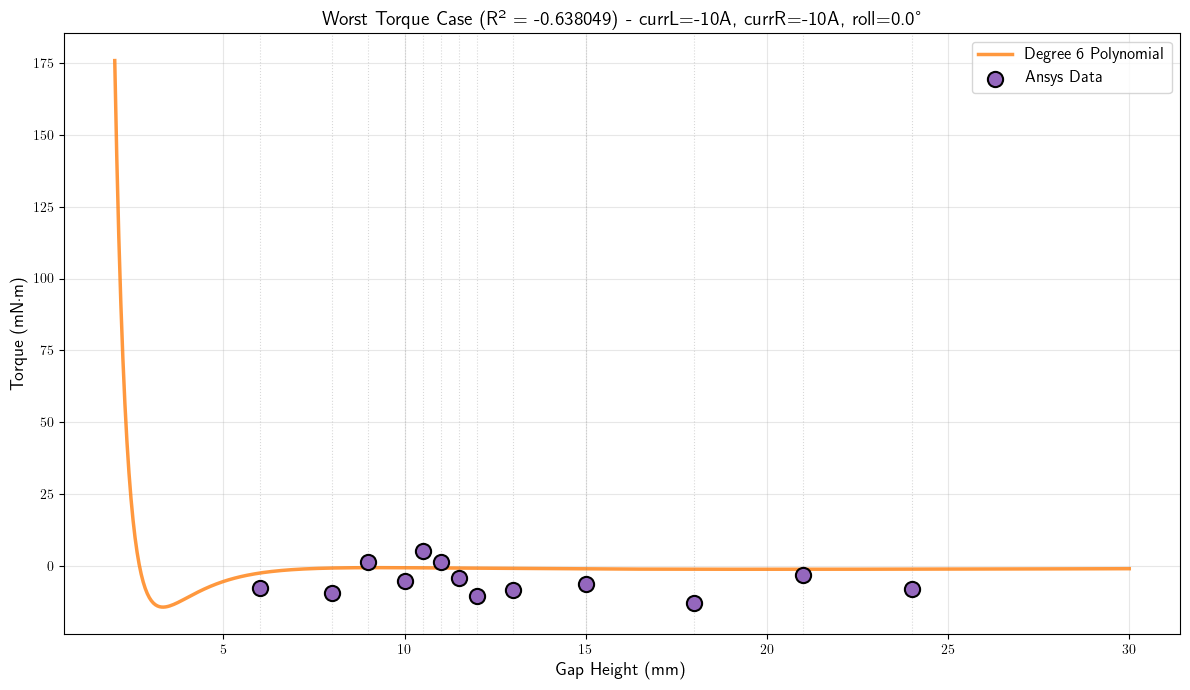

Worst-case torque prediction achieves R² = -0.638049


In [270]:
# Get worst torque segment data
worst_torque_data = magDf.iloc[worst_torque_segment['start']:worst_torque_segment['end']]
worst_torque_currL = worst_torque_segment['currL']
worst_torque_currR = worst_torque_segment['currR']
worst_torque_roll = worst_torque_segment['roll']
worst_torque_r2 = worst_torque_segment['r2']

# Create fine grid for this worst segment
gap_fine_worst_torque = np.linspace(2, 30, 500)
X_worst_torque_fine = pd.DataFrame({
    'currL [A]': [worst_torque_currL] * 500,
    'currR [A]': [worst_torque_currR] * 500,
    'rollDeg [deg]': [worst_torque_roll] * 500,
    'invGap': 1/gap_fine_worst_torque
})

# Get predictions
X_worst_torque_poly = poly_best.transform(X_worst_torque_fine)
y_worst_torque_pred = model_best.predict(X_worst_torque_poly)

# Extract actual data
gap_worst_torque_actual = worst_torque_data['GapHeight [mm]'].values
torque_worst_actual = worst_torque_data['YokeTorque.Torque [mNewtonMeter]'].values

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Plot polynomial curve for TORQUE
ax.plot(gap_fine_worst_torque, y_worst_torque_pred[:, 1], '-', linewidth=2.5, 
        label=f'Degree {best_degree} Polynomial', color='#ff7f0e', alpha=0.8)

# Plot actual data points
ax.scatter(gap_worst_torque_actual, torque_worst_actual, s=120, marker='o', 
          color='#9467bd', edgecolors='black', linewidths=1.5,
          label='Ansys Data', zorder=5)

# Formatting
ax.set_xlabel('Gap Height (mm)', fontsize=13)
ax.set_ylabel('Torque (mN·m)', fontsize=13)
ax.set_title(f'Worst Torque Case (R² = {worst_torque_r2:.6f}) - currL={worst_torque_currL:.0f}A, currR={worst_torque_currR:.0f}A, roll={worst_torque_roll:.1f}°', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)

# Add vertical lines at data points
for gap_point in gap_worst_torque_actual:
    ax.axvline(gap_point, color='gray', linestyle=':', alpha=0.3, linewidth=0.8)

plt.tight_layout()
plt.show()

print(f"Worst-case torque prediction achieves R² = {worst_torque_r2:.6f}")

### We can see here that at roll angle and current differential of 0 (when torque will be very close to 0):

There is significant overfitting to noise, but within the operating range of 6 - 24 mm, there is never more variation than there would be with simple linear interpolation.

Hopefully this means we are ok

### Export Model Summary

Display key model information before exporting.

In [271]:
print("=" * 60)
print("MODEL EXPORT SUMMARY")
print("=" * 60)
print(f"\nModel Type: Polynomial Regression")
print(f"Polynomial Degree: {best_degree}")
print(f"Number of Features: {poly_best.n_features_in_}")
print(f"Number of Polynomial Terms: {poly_best.n_output_features_}")
print(f"\nInput Features:")
print("  - currL [A]")
print("  - currR [A]")
print("  - rollDeg [deg]")
print("  - invGap (1/GapHeight)")
print(f"\nOutputs:")
print("  - YokeForce.Force_z [newton]")
print("  - YokeTorque.Torque [mNewtonMeter]")
print(f"\nModel Performance:")
print(f"  Force R² Score: {r2_score(y.iloc[:, 0].values, y_pred_full[:, 0]):.6f}")
print(f"  Torque R² Score: {torque_r2_overall:.6f}")
print(f"\nModel Coefficients Shape:")
print(f"  Force coefficients: {model_best.coef_[0].shape}")
print(f"  Torque coefficients: {model_best.coef_[1].shape}")
print("=" * 60)

MODEL EXPORT SUMMARY

Model Type: Polynomial Regression
Polynomial Degree: 6
Number of Features: 4
Number of Polynomial Terms: 210

Input Features:
  - currL [A]
  - currR [A]
  - rollDeg [deg]
  - invGap (1/GapHeight)

Outputs:
  - YokeForce.Force_z [newton]
  - YokeTorque.Torque [mNewtonMeter]

Model Performance:
  Force R² Score: 0.999967
  Torque R² Score: 0.999895

Model Coefficients Shape:
  Force coefficients: (210,)
  Torque coefficients: (210,)


### Create Standalone Python Predictor Class

Generate a self-contained Python module that can be imported into your simulator without scikit-learn dependencies.

In [272]:
# Generate standalone predictor class
predictor_code = f'''"""
Magnetic Levitation Force and Torque Predictor
Generated from polynomial regression model (degree {best_degree})

Performance:
  - Force R²: {r2_score(y.iloc[:, 0].values, y_pred_full[:, 0]):.6f}
  - Torque R²: {torque_r2_overall:.6f}

Usage:
    predictor = MaglevPredictor()
    force, torque = predictor.predict(currL=-15, currR=-15, roll=1.0, gap_height=10.0)
"""

import numpy as np
from itertools import combinations_with_replacement

class MaglevPredictor:
    def __init__(self):
        """Initialize the magnetic levitation force/torque predictor."""
        self.degree = {best_degree}
        self.n_features = 4  # currL, currR, roll, invGap
        
        # Force model coefficients
        self.force_intercept = {model_best.intercept_[0]}
        self.force_coef = np.array({model_best.coef_[0].tolist()})
        
        # Torque model coefficients  
        self.torque_intercept = {model_best.intercept_[1]}
        self.torque_coef = np.array({model_best.coef_[1].tolist()})
        
    def _polynomial_features(self, X):
        """
        Generate polynomial features up to specified degree.
        Mimics sklearn's PolynomialFeatures with include_bias=True.
        
        Args:
            X: numpy array of shape (n_samples, 4) with [currL, currR, roll, invGap]
            
        Returns:
            Polynomial features array
        """
        n_samples = X.shape[0]
        
        # Start with bias term (column of ones)
        features = [np.ones(n_samples)]
        
        # Add original features
        for i in range(self.n_features):
            features.append(X[:, i])
        
        # Add polynomial combinations
        for deg in range(2, self.degree + 1):
            for combo in combinations_with_replacement(range(self.n_features), deg):
                term = np.ones(n_samples)
                for idx in combo:
                    term *= X[:, idx]
                features.append(term)
        
        return np.column_stack(features)
    
    def predict(self, currL, currR, roll, gap_height):
        """
        Predict force and torque for given operating conditions.
        
        Args:
            currL: Left coil current in Amps
            currR: Right coil current in Amps
            roll: Roll angle in degrees
            gap_height: Gap height in mm
            
        Returns:
            tuple: (force [N], torque [mN·m])
        """
        # Compute inverse gap (critical transformation!)
        invGap = 1.0 / gap_height
        
        # Create input array
        X = np.array([[currL, currR, roll, invGap]])
        
        # Generate polynomial features
        X_poly = self._polynomial_features(X)
        
        # Compute predictions
        force = self.force_intercept + np.dot(X_poly, self.force_coef)[0]
        torque = self.torque_intercept + np.dot(X_poly, self.torque_coef)[0]
        
        return force, torque
    
    def predict_batch(self, currL_array, currR_array, roll_array, gap_height_array):
        """
        Predict force and torque for multiple operating conditions.
        
        Args:
            currL_array: Array of left coil currents [A]
            currR_array: Array of right coil currents [A]
            roll_array: Array of roll angles [deg]
            gap_height_array: Array of gap heights [mm]
            
        Returns:
            tuple: (force_array [N], torque_array [mN·m])
        """
        # Convert to numpy arrays
        currL_array = np.asarray(currL_array)
        currR_array = np.asarray(currR_array)
        roll_array = np.asarray(roll_array)
        gap_height_array = np.asarray(gap_height_array)
        
        # Compute inverse gaps
        invGap_array = 1.0 / gap_height_array
        
        # Stack into feature matrix
        X = np.column_stack([currL_array, currR_array, roll_array, invGap_array])
        
        # Generate polynomial features
        X_poly = self._polynomial_features(X)
        
        # Compute predictions
        force_array = self.force_intercept + np.dot(X_poly, self.force_coef)
        torque_array = self.torque_intercept + np.dot(X_poly, self.torque_coef)
        
        return force_array, torque_array


if __name__ == "__main__":
    # Example usage
    predictor = MaglevPredictor()
    
    # Single prediction
    force, torque = predictor.predict(currL=-15, currR=-15, roll=1.0, gap_height=10.0)
    print(f"Single prediction:")
    print(f"  Force: {{force:.2f}} N")
    print(f"  Torque: {{torque:.2f}} mN·m")
    
    # Batch prediction
    currL = np.array([-15, -15, -10])
    currR = np.array([-15, -10, -10])
    roll = np.array([0, 0.5, 1.0])
    gap = np.array([10, 12, 15])
    
    forces, torques = predictor.predict_batch(currL, currR, roll, gap)
    print(f"\\nBatch prediction:")
    for i in range(len(forces)):
        print(f"  Condition {{i+1}}: Force={{forces[i]:.2f}} N, Torque={{torques[i]:.2f}} mN·m")
'''

# Save to file
predictor_filename = 'maglev_predictor.py'
with open(predictor_filename, 'w') as f:
    f.write(predictor_code)

print(f"✓ Saved standalone predictor: {predictor_filename}")
print(f"\nThis module:")
print(f"  - Has NO scikit-learn dependency (only numpy)")
print(f"  - Can be imported directly into your simulator")
print(f"  - Includes both single and batch prediction methods")
print(f"  - Implements polynomial feature generation internally")
print(f"\nTo use:")
print(f"```python")
print(f"from maglev_predictor import MaglevPredictor")
print(f"predictor = MaglevPredictor()")
print(f"force, torque = predictor.predict(currL=-15, currR=-15, roll=1.0, gap_height=10.0)")
print(f"```")

✓ Saved standalone predictor: maglev_predictor.py

This module:
  - Has NO scikit-learn dependency (only numpy)
  - Can be imported directly into your simulator
  - Includes both single and batch prediction methods
  - Implements polynomial feature generation internally

To use:
```python
from maglev_predictor import MaglevPredictor
predictor = MaglevPredictor()
force, torque = predictor.predict(currL=-15, currR=-15, roll=1.0, gap_height=10.0)
```


### Test the Exported Predictor

Verify the standalone predictor produces identical results to the original model.

In [273]:
# Import the standalone predictor (reload to get latest version)
import importlib
import maglev_predictor
importlib.reload(maglev_predictor)
from maglev_predictor import MaglevPredictor

# Create predictor instance
standalone_predictor = MaglevPredictor()

# Test cases
test_cases = [
    {'currL': -15, 'currR': -15, 'roll': 0.0, 'gap': 10.0},
    {'currL': -15, 'currR': -15, 'roll': 1.0, 'gap': 10.0},
    {'currL': -15, 'currR': -10, 'roll': 0.5, 'gap': 12.0},
    {'currL': -10, 'currR': -10, 'roll': 2.0, 'gap': 15.0},
]

print("Validation: Comparing Standalone Predictor vs Original Model")
print("=" * 80)

for i, case in enumerate(test_cases):
    # Standalone predictor
    force_standalone, torque_standalone = standalone_predictor.predict(
        case['currL'], case['currR'], case['roll'], case['gap']
    )
    
    # Original model
    X_test = pd.DataFrame({
        'currL [A]': [case['currL']],
        'currR [A]': [case['currR']],
        'rollDeg [deg]': [case['roll']],
        'invGap': [1/case['gap']]
    })
    X_test_poly = poly_best.transform(X_test)
    y_test_pred = model_best.predict(X_test_poly)
    force_original = y_test_pred[0, 0]
    torque_original = y_test_pred[0, 1]
    
    # Compare
    force_diff = abs(force_standalone - force_original)
    torque_diff = abs(torque_standalone - torque_original)
    
    print(f"\nTest Case {i+1}: currL={case['currL']}A, currR={case['currR']}A, " + 
          f"roll={case['roll']}°, gap={case['gap']}mm")
    print(f"  Force:  Standalone={force_standalone:9.4f} N | Original={force_original:9.4f} N | Diff={force_diff:.2e}")
    print(f"  Torque: Standalone={torque_standalone:9.4f} mN·m | Original={torque_original:9.4f} mN·m | Diff={torque_diff:.2e}")
    
    # Verify match (should be essentially identical, accounting for floating point)
    assert force_diff < 1e-8, f"Force mismatch in test case {i+1}"
    assert torque_diff < 1e-8, f"Torque mismatch in test case {i+1}"

print("\n" + "=" * 80)
print("✓ All tests passed! Standalone predictor matches original model perfectly.")
print("\nThe standalone predictor is ready for integration into your simulator!")

Validation: Comparing Standalone Predictor vs Original Model

Test Case 1: currL=-15A, currR=-15A, roll=0.0°, gap=10.0mm
  Force:  Standalone= 103.3304 N | Original= 103.3304 N | Diff=0.00e+00
  Torque: Standalone=  -0.8561 mN·m | Original=  -0.8561 mN·m | Diff=2.08e-13

Test Case 2: currL=-15A, currR=-15A, roll=1.0°, gap=10.0mm
  Force:  Standalone= 104.0520 N | Original= 104.0520 N | Diff=1.14e-13
  Torque: Standalone= 450.3916 mN·m | Original= 450.3916 mN·m | Diff=3.41e-13

Test Case 3: currL=-15A, currR=-10A, roll=0.5°, gap=12.0mm
  Force:  Standalone=  75.0401 N | Original=  75.0401 N | Diff=5.68e-14
  Torque: Standalone= 390.7023 mN·m | Original= 390.7023 mN·m | Diff=1.71e-13

Test Case 4: currL=-10A, currR=-10A, roll=2.0°, gap=15.0mm
  Force:  Standalone=  50.4344 N | Original=  50.4344 N | Diff=1.42e-14
  Torque: Standalone= 303.7401 mN·m | Original= 303.7401 mN·m | Diff=0.00e+00

✓ All tests passed! Standalone predictor matches original model perfectly.

The standalone predict